## Med 6: 22,7 cm cobre

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq
import pandas as pd

In [2]:
file_path = "C:/Users/FIUBA/Desktop/Labo 4/mod young/mediciones24-2/med6-24-2-cobre-22-7cm0.csv"
df = pd.read_csv(file_path)

df.columns = ["t","V"]

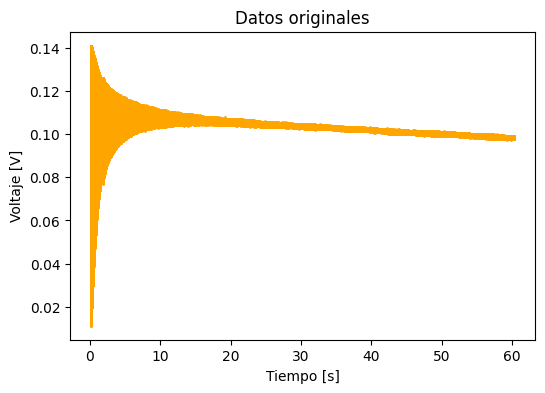

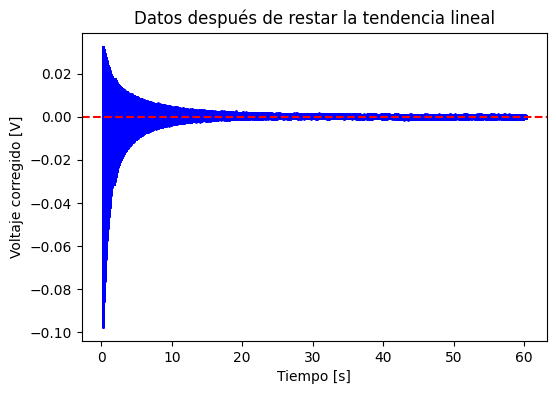

Ecuación de la recta ajustada: V(t) = -0.000170 * t + 0.108619
mean: 4.896581562332786e-05


In [3]:
plt.figure(figsize=(6, 4))
plt.plot(df["t"], df["V"], '.', markersize=2, color="orange")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [V]")
plt.title("Datos originales")
plt.show()

# Seleccionar los últimos puntos para el ajuste lineal (por ejemplo, últimos 20% de los datos)
fraction = 0.2
n_points = int(len(df) * fraction)
df_tail = df.iloc[-n_points:]

# Ajuste lineal (mínimos cuadrados)
p = np.polyfit(df_tail["t"], df_tail["V"], 1)  # p[0] es la pendiente, p[1] es la intersección

# Crear la recta ajustada
recta_ajustada = np.polyval(p, df["t"])

# Restar la recta ajustada a los datos originales
df["V1_corregido"] = df["V"] - recta_ajustada

plt.figure(figsize=(6, 4))
plt.plot(df["t"], df["V1_corregido"], '.', markersize=2, color="blue")
plt.axhline(np.mean(df["V1_corregido"]), color='red', linestyle='--', label="Media")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje corregido [V]")
plt.title("Datos después de restar la tendencia lineal")
plt.show()

# Mostrar la ecuación de la recta ajustada
print(f"Ecuación de la recta ajustada: V(t) = {p[0]:.6f} * t + {p[1]:.6f}")
print(f"mean: {np.mean(df['V1_corregido'])}")


### fft

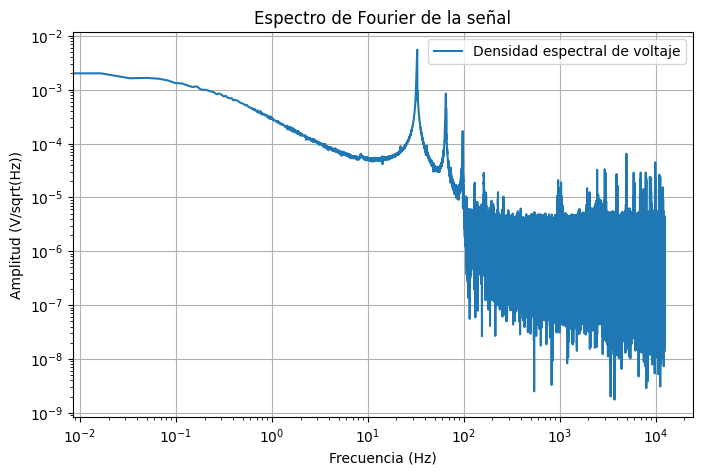

In [4]:
N = len(df["t"])  # Número de puntos
dt = np.mean(np.diff(df["t"]))  # Paso de tiempo
fs = 1 / dt  # Frecuencia de muestreo

V_fft = np.fft.fft(df["V1_corregido"])  # Transformada de Fourier
freqs = np.fft.fftfreq(N, d=dt)  # Frecuencias asociadas

V_fft = V_fft[:N//2]  # Tomamos solo la mitad positiva
freqs = freqs[:N//2]  # Frecuencias positivas
S_v = np.abs(V_fft) / np.sqrt(fs * N)  # Densidad espectral de voltaje

plt.figure(figsize=(8,5))
plt.loglog(freqs, S_v, label='Densidad espectral de voltaje')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud (V/sqrt(Hz))')
plt.title('Espectro de Fourier de la señal')
plt.legend()
plt.grid()
plt.show()

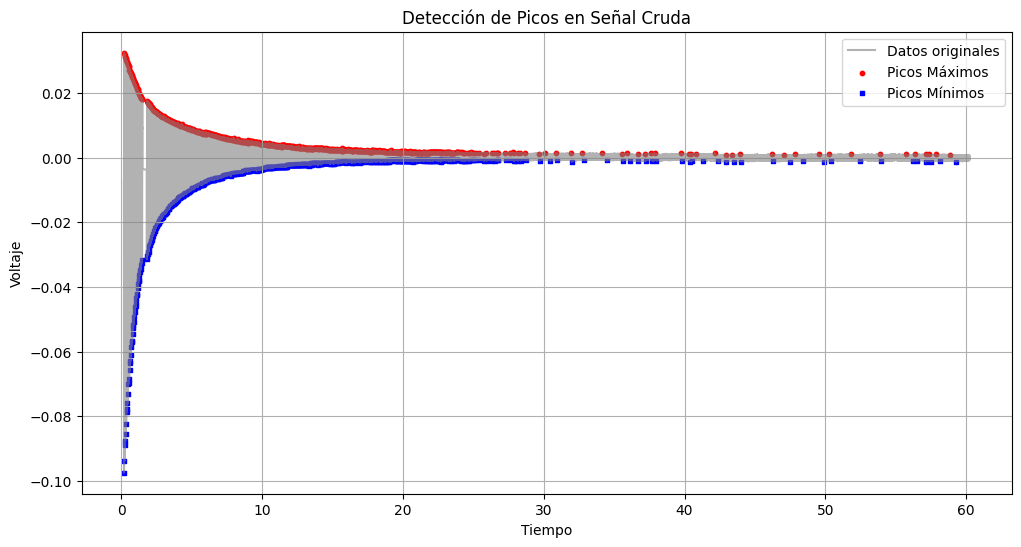

In [39]:
from scipy.signal import savgol_filter

#Si la señal es muy ruidosa y es necesario se puede filtrar un poco la señal:
# V_smooth = savgol_filter(V, window_length=11, polyorder=2)  # Suaviza manteniendo forma de la señal, cambiar voltajes por V_smooth
#Encontrar picos máximos
voltaje = df["V1_corregido"] - np.mean(df["V1_corregido"])
peaks_max, _ = find_peaks(voltaje, distance=6, prominence=0.002)
peaks_min, _ = find_peaks(-voltaje, distance=6, prominence=0.002)# Para mínimos, buscamos picos en la señal invertida

#Crear listas con los valores de los picos
t_max = df["t"][peaks_max]
V_max = voltaje[peaks_max]

t_min = df["t"][peaks_min]
V_min = voltaje[peaks_min]

#Graficar los datos crudos con los picos detectados
plt.figure(figsize=(12, 6))
plt.plot(df["t"], voltaje, label='Datos originales', color='gray', alpha=0.6)
plt.scatter(t_max, V_max, label='Picos Máximos', color='red', marker='o', s=10)
plt.scatter(t_min, V_min, label='Picos Mínimos', color='blue', marker='s', s=10)

# Detalles del gráfico
plt.xlabel('Tiempo')
plt.ylabel('Voltaje')
plt.title('Detección de Picos en Señal Cruda')
plt.legend()
plt.grid(True)
plt.show()

### fourier

Frecuencias de los picos detectados en la región 20-80 Hz:
[32.88606943 33.11930397 65.35564863]


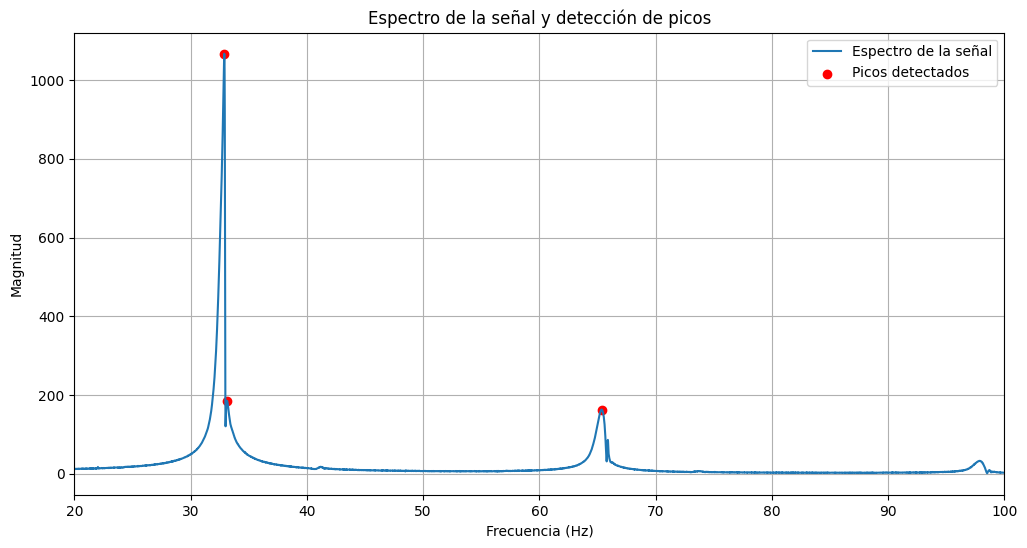

In [ ]:
num_puntos_finales = 2000  
offset = np.mean(df["V1_corregido"][-num_puntos_finales:])
V_ajustada = df["V1_corregido"] - offset  

# Obtener el tiempo de muestreo
dt = np.mean(np.diff(df["t"]))  # Diferencia promedio entre puntos de tiempo
fs = 1 / dt  # Frecuencia de muestreo

# Aplicar FFT
N = len(V_ajustada)
frequencies = fftfreq(N, d=dt)  # Eje de frecuencias
spectrum = np.abs(fft(V_ajustada))  # Magnitud del espectro

# Detectar picos en el espectro
peaks, _ = find_peaks(spectrum, height=np.max(spectrum) * 0.1)

# Obtener frecuencias de los picos
peak_freqs = frequencies[peaks]

# Filtrar las frecuencias entre 20 y 80 Hz
peak_freqs_filtered = peak_freqs[(peak_freqs >= 20) & (peak_freqs <= 80)]

# Imprimir las frecuencias detectadas en la región 20-80 Hz
print("Frecuencias de los picos detectados en la región 20-100 Hz:")
print(peak_freqs_filtered)

# Graficar el espectro con los picos detectados
plt.figure(figsize=(12, 6))
plt.plot(frequencies[:N // 2], spectrum[:N // 2], label="Espectro de la señal")  # Solo parte positiva
plt.scatter(peak_freqs_filtered, spectrum[peaks[(peak_freqs >= 20) & (peak_freqs <= 100)]], 
            color='red', label="Picos detectados", marker='o')
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Magnitud")
plt.xlim(20, 100)
plt.title("Espectro de la señal y detección de picos")
plt.legend()
plt.grid(True)
plt.show()

In [43]:
print(len(S_v[(freqs >= 20) & (freqs <= 100)]))

4802


### buscamos alpha

In [15]:
from scipy.optimize import curve_fit
from scipy.stats import chi2

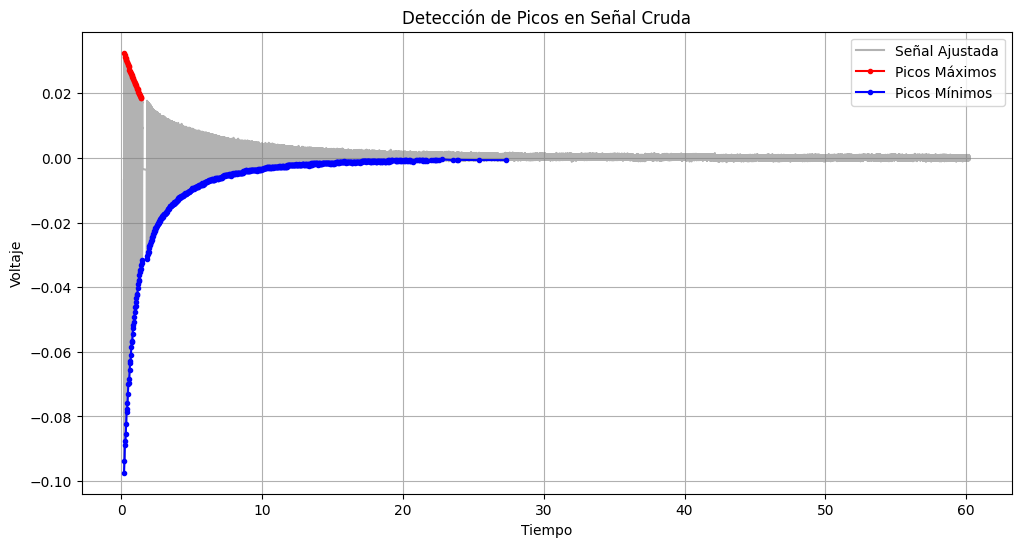

In [17]:
num_puntos_finales = 2000  # Ajusta según tu señal
offset = np.mean(df["V1_corregido"][-num_puntos_finales:])
V_ajustada = df["V1_corregido"] - offset # Restar el offset para que al final la señal quede en 0

peaks_max, _ = find_peaks(V_ajustada, height=0.001, distance=10, prominence=0.05)
peaks_min, _ = find_peaks(-V_ajustada, prominence=0.001, distance=5, width=40)

#Crear listas con los valores de los picos
t_max = df["t"][peaks_max]
V_max = V_ajustada[peaks_max]

t_min = df["t"][peaks_min]
V_min = V_ajustada[peaks_min]

#Graficar los datos crudos con los picos detectados
plt.figure(figsize=(12, 6))
plt.plot(df["t"], V_ajustada, label="Señal Ajustada", color='gray', alpha=0.6)
plt.plot(t_max, V_max, label='Picos Máximos', color='red', marker='.')
plt.plot(t_min, V_min, label='Picos Mínimos', color='blue', marker='.')

# Detalles del gráfico
plt.xlabel('Tiempo')
plt.ylabel('Voltaje')
plt.title('Detección de Picos en Señal Cruda')
plt.legend()
plt.grid(True)
plt.show()


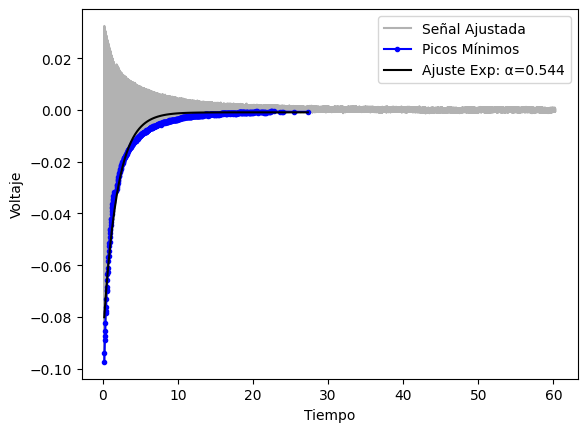

α=0.544 ± 0.006


In [24]:
def exp_decay(t, A, alpha):
    return A * np.exp(-alpha * t) - 0.0009

popt, pcov = curve_fit(exp_decay, t_min, V_min, p0=[max(V_min), 0.1])
A_fit, alpha_fit = popt

# Calcular el error de alpha a partir de la matriz de covarianza
alpha_error = np.sqrt(pcov[1, 1])  

t_fit = np.linspace(min(t_min), max(t_min), 100)
V_fit = exp_decay(t_fit, *popt)

plt.plot(df["t"], V_ajustada, label="Señal Ajustada", color='gray', alpha=0.6)
plt.plot(t_min, V_min, label='Picos Mínimos', color='blue', marker='.')
plt.plot(t_fit, V_fit, label=f'Ajuste Exp: α={alpha_fit:.3f}', color='black')

plt.xlabel('Tiempo')
plt.ylabel('Voltaje')
plt.legend()
plt.show()

print(f'α={alpha_fit:.3f} ± {alpha_error:.3f}')

Ajuste para picos máximos:
A = 0.0279, α = 0.2852 +- 0.0027, C = 0.0020

Ajuste para picos mínimos:
A = -0.0904, α = 0.5930+- 0.0065, C = -0.0022


C:\Users\FIUBA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


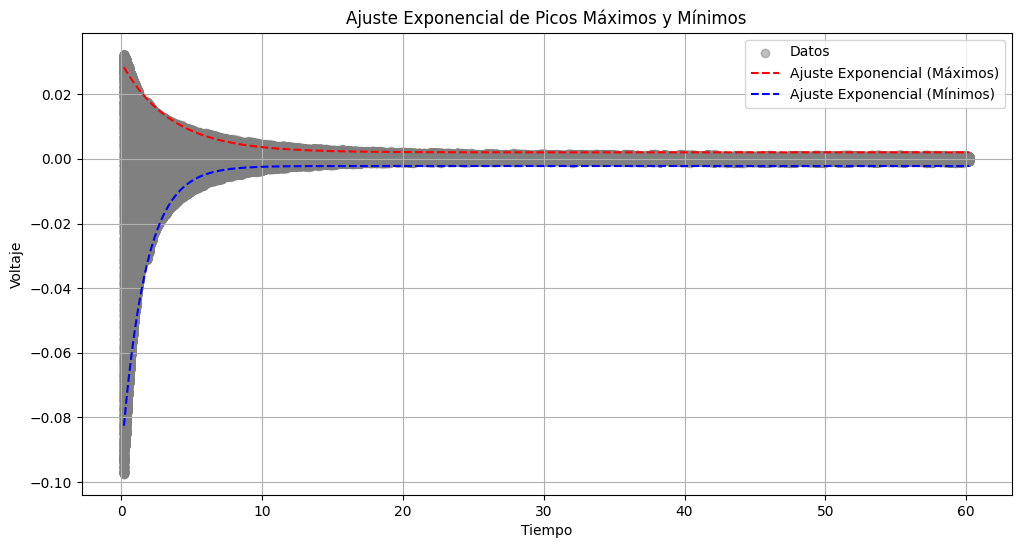

In [40]:
def exponencial(t, A, alpha, C):
    return A * np.exp(-alpha * t) + C

#Ajustar picos máximos
popt_max, pcov_max = curve_fit(exponencial, t_max, V_max, p0=[max(V_max), 0.1, min(V_max)])

#Ajustar picos mínimos
popt_min, pcov_min = curve_fit(exponencial, t_min, V_min, p0=[min(V_min), 0.1, max(V_min)])


plt.figure(figsize=(12, 6))
plt.scatter(df["t"], V_ajustada, label='Datos', color='gray', alpha=0.5)


# Curvas ajustadas
t_fit = np.linspace(min(df["t"]), max(df["t"]), 1000)

V_fit_max = exponencial(t_fit, *popt_max)
erroralfa_max = np.sqrt(np.diag(pcov_max))[1]

V_fit_min = exponencial(t_fit, *popt_min)
erroralfa_min = np.sqrt(np.diag(pcov_min))[1]

alfamax = popt_max[1]
alfamin = popt_min[1]

print("Ajuste para picos máximos:")
print(f"A = {popt_max[0]:.4f}, α = {alfamax:.4f} +- {erroralfa_max:.4f}, C = {popt_max[2]:.4f}")

print("\nAjuste para picos mínimos:")
print(f"A = {popt_min[0]:.4f}, α = {alfamin:.4f}+- {erroralfa_min:.4f}, C = {popt_min[2]:.4f}")


plt.plot(t_fit, V_fit_max, label='Ajuste Exponencial (Máximos)', color='red', linestyle='--')
plt.plot(t_fit, V_fit_min, label='Ajuste Exponencial (Mínimos)', color='blue', linestyle='--')


plt.xlabel('Tiempo')
plt.ylabel('Voltaje')
plt.title('Ajuste Exponencial de Picos Máximos y Mínimos')
plt.legend()
plt.grid(True)
plt.show()

### calculamos E

In [25]:
L = 0.227  
n = 1  

k_n = (n * np.pi) / L
k_n

13.839615214051951

In [41]:
rho = 8960 * (np.pi * (d / 2) ** 2)
print(rho)
f1= 32.88606943

0.1759+/-0.0007


In [44]:
from uncertainties import ufloat

def calcular_modulo_young(L, d, rho, f1, alpha):
    A = np.pi * (d / 2) ** 2  
    I = (np.pi * d**4) / 64 
    w = 2 * np.pi * f1  
    k = 13.839615214051951 
    
    E = (A * rho * (w**2 + alpha**2)) / (I * k**4)  
    return E

L = ufloat(0.227, 0.001)
d = ufloat(0.005, 1e-5)
rho = ufloat(0.1759, 90)
f1 = ufloat(32.88606943, 25000 / 4802)
alpha = ufloat(0.544, 0.005)

E = calcular_modulo_young(L, d, rho, f1, alpha)

print(f"Módulo de Young: {E:.2e} Pa")

Módulo de Young: (0.01+/-6.70)e+07 Pa


In [46]:
alfa = 0.5930
d = 0.5/100 # en metros
rho = (77/1000)*(1/(0.22))  #del cobre
I = (np.pi * (d)**4)/64
L = 0.22 #en metros
k = 1.875/L
frecuencia_dominante = 32.88606943

#k = (2*np.pi)/(670*(10**(-9)))
E = ((frecuencia_dominante*2*np.pi)**2 + alfa**2) * rho /(I*(k)**4)
print(f"Módulo de Young: {E / 1e9:.2f} GPa")

Módulo de Young: 92.32 GPa


In [52]:
L_err = 0.005 
d_err = 1*10**(-5)
rho_err = 0.0033 # por impuresas me tiro chat
f_err = 25000/746827 # frec de meustreo/numero de puntos de la fft
alpha_err = 0.006 # sale de la matriz de covarianza

from uncertainties import ufloat

alfa_u = ufloat(alfa, alpha_err)
d_u = ufloat(d, d_err)
rho_u = ufloat(rho, rho_err)
L_u = ufloat(L, L_err)
f_u = ufloat(frecuencia_dominante, f_err)

I_u = (np.pi * d_u**4) / 64
k_u = 1.875 / L_u

E_u = ((f_u * 2 * np.pi)**2 + alfa_u**2) * rho_u / (I_u * k_u**4)

E_GPa_u = E_u / 1e9

E_GPa_u
print(f"Módulo de Young: {E_GPa_u:.2f} GPa")

Módulo de Young: 92.32+/-8.47 GPa
